# Algoritmo Genético para Feature Selection

O algoritmo genético é uma metaheurística que simula o processo de seleção natural e evolução, através dos operadores de mutação, cruzamento, seleção e elitismo. Tal metaheurística é muito utilizada em problemas complexos de otimização, sendo capaz também de lidar com variáveis binárias, discretas e inteiras.

Vamos aplicar o algoritmo genético para realizar um feature selection em um dataset da biblioteca do scikit-learn.

In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [335]:
dados=load_breast_cancer()
df = pd.DataFrame(dados['data'],columns=dados['feature_names'])
target=dados["target"]

In [336]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [337]:
X_train, X_test, y_train, y_test = train_test_split(df,target, test_size=0.33)

# Criando o Algoritmo Genético

In [398]:
def inicializa_populacao(tamanho,features):
    
    population = []
    
    for i in range(tamanho):
    
        cromossomo = np.ones(features,dtype=np.bool)
        
        cromossomo[:int(0.3*features)]= False
        
        np.random.shuffle(cromossomo)
        
        population.append(cromossomo)
    
    return population


def fitness(populacao, X_train, y_train, X_test, y_test,svm_model):
    
    score = []
    
    for cromossomo in populacao:
        
        svm_model.fit(X_train.iloc[:,cromossomo],y_train)
        
        y_pred = svm_model.predict(X_test.iloc[:,cromossomo])
        
        score.append(accuracy_score(y_test,y_pred))
    
    score, populacao = np.array(score), np.array(populacao) 
    
    
    return score, populacao


def torneio(scores, populacao, rounds):
    
    placar = []
    posi = []
    
    for i in range(rounds):
        
        posic = int(np.random.uniform(0,len(scores-1)))
        
        if i == 0:
        
            placar.append(scores[posic])
            posi.append(posic)
            
        else:
            
            if placar[-1] < scores[posic]:
            
                placar.append(scores[posic])
                posi.append(posic)
        
        
    return posi[-1], placar


def crossover(pai, mae, taxa):
    
    filho1 = np.copy(pai)
    filho2 = np.copy(mae)
    
    for i in range(len(pai)):
    
        r = np.random.rand()
        
        if r<=taxa:
        
            filho1[i] = mae[i]
            filho2[i] = pai[i]

        
    return filho1, filho2


def mutacao(pop,taxa):
    
    for i in range(0,np.shape(pop)[0]):
        
        for j in range(np.shape(pop)[1]):
            
            if np.random.rand() < taxa:
                
                pop[i][j]= not pop[i][j]
        
    
    return pop


def GA(tamanho,features,rounds,taxa_mutacao, taxa_crossover,max_gen,X_train, X_test, y_train, y_test, model):
    
    best_cromo = []
    
    best_score = []
    
    mean_score = []
    
    pop = inicializa_populacao(tamanho,features)

    
    for i in range(max_gen):
        
        scores, pop_fit = fitness(pop, X_train, y_train, X_test, y_test, model) 
        
        
        mean_score.append(np.mean(scores))
        best_score.append(np.max(scores))
        best_cromo.append(pop_fit[np.argmax(scores)])
        
        pop_ = []

        for j in range(int(len(pop)/2)):
        
            m,placar = torneio(scores, pop_fit, rounds)
                       
            mae = pop_fit[m]
     
            p,placar = torneio(scores, pop_fit, rounds)
            
            pai = pop_fit[p]

            
            filho1, filho2 = crossover(pai, mae, taxa_crossover)
            
            pop_.append(filho1)
            pop_.append(filho2)
            
        pop_ = mutacao(pop_,taxa_mutacao)
        
        pop = np.copy(pop_)
        
    return best_score, mean_score, best_cromo

In [407]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [433]:
score_best_dt, score_mean_dt, best_cromo_dt = GA(200,30,100,0.1, 0.8,100,X_train, X_test, y_train, y_test, DecisionTreeClassifier())

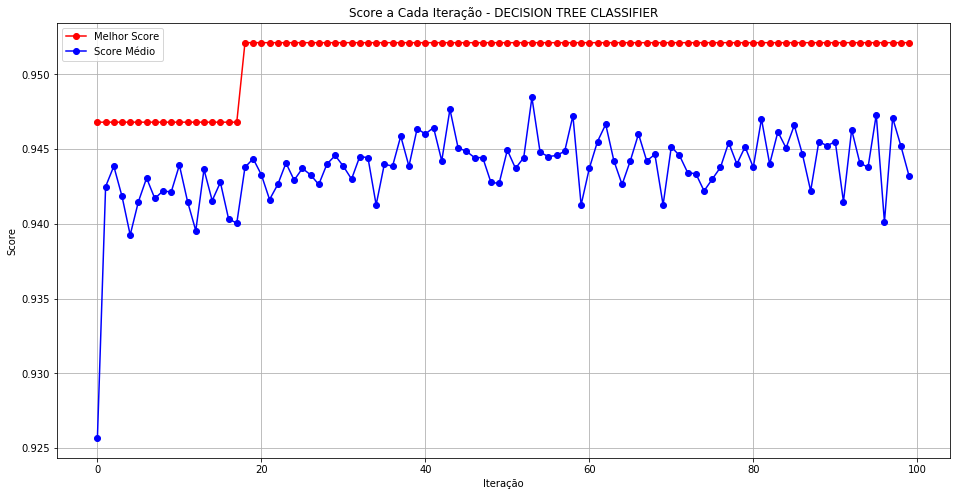

In [434]:
plt.figure(figsize=(16,8))
plt.plot(score_best_svm, '-o', color='red', label='Melhor Score')
plt.title('Score a Cada Iteração - DECISION TREE CLASSIFIER')
plt.plot(score_mean_svm, '-o', color='blue', label='Score Médio')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Iteração')
plt.grid()

In [445]:
best_indiv = np.argmax(score_best_dt)

best_cromo_dt[best_indiv]

array([False, False,  True,  True, False, False,  True, False, False,
       False,  True,  True, False,  True,  True,  True, False, False,
        True, False, False, False, False,  True,  True,  True,  True,
       False,  True, False])

Features selecionadas:

In [447]:
X_train.iloc[:,best_cromo_dt[best_indiv]]

,mean perimeter,mean area,mean concavity,radius error,texture error,area error,smoothness error,compactness error,symmetry error,worst area,worst smoothness,worst compactness,worst concavity,worst symmetry
412,59.75,268.8,0.037350,0.1186,1.1820,6.802,0.005515,0.026740,0.01951,301.0,0.10860,0.18870,0.186800,0.2376
219,128.00,1223.0,0.114500,0.7392,1.3210,109.900,0.005539,0.026440,0.01332,2477.0,0.14080,0.40970,0.399500,0.2713
548,61.05,285.7,0.023370,0.2957,1.3630,18.240,0.007440,0.011230,0.02203,364.2,0.11990,0.09546,0.093500,0.2552
58,82.61,527.2,0.000692,0.4040,1.2140,32.960,0.007491,0.008593,0.02190,624.1,0.10210,0.06191,0.001845,0.2439
130,79.08,455.8,0.028550,0.2005,0.8163,15.240,0.006773,0.024560,0.02662,545.2,0.14270,0.25850,0.099150,0.3469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,88.37,596.6,0.020450,0.2541,0.6218,23.120,0.003728,0.014150,0.01647,745.3,0.08484,0.12330,0.109100,0.2542
318,60.07,244.5,0.197500,0.4653,1.9110,24.200,0.009845,0.065900,0.03491,297.1,0.12210,0.37480,0.460900,0.3135
345,66.20,321.6,0.035810,0.3380,2.5090,19.330,0.017360,0.046710,0.03675,357.1,0.13600,0.16360,0.071620,0.2434
356,85.09,512.0,0.096030,0.3106,1.5100,21.570,0.007807,0.039320,0.02860,591.2,0.13430,0.26580,0.257300,0.3113


# Comparação com RandomForest

In [448]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(X_train, y_train)

RandomForestClassifier()

In [450]:
for name, score in zip(dados['feature_names'],rf.feature_importances_):
    print(name,score)

mean radius 0.05522124574073093
mean texture 0.01773333581814114
mean perimeter 0.05264836776317146
mean area 0.028376127399936984
mean smoothness 0.00554778053694842
mean compactness 0.00936138164250398
mean concavity 0.05758892301082759
mean concave points 0.054599378335026906
mean symmetry 0.0023106081087411385
mean fractal dimension 0.003606498540504001
radius error 0.010532595552822568
texture error 0.004439312972774307
perimeter error 0.016509110791014716
area error 0.062376109653510266
smoothness error 0.006313744392808826
compactness error 0.0027369845896616225
concavity error 0.00886967566689911
concave points error 0.004120695937993622
symmetry error 0.002564325267549126
fractal dimension error 0.006601432959934114
worst radius 0.13536653623777548
worst texture 0.015235732438391223
worst perimeter 0.13311893435745964
worst area 0.09245894217559716
worst smoothness 0.013064853432838038
worst compactness 0.015528183999813141
worst concavity 0.04198955949873387
worst concave poi

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 <a list of 30 Text xticklabel objects>)

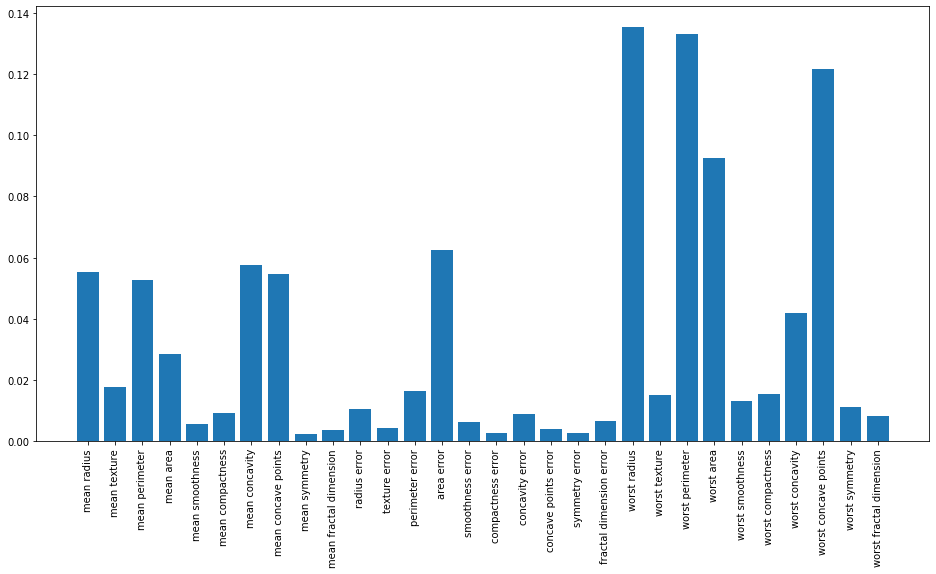

In [454]:
plt.figure(figsize=(16,8))
plt.bar(dados['feature_names'],rf.feature_importances_)
plt.xticks(rotation=90)

In [476]:
features = pd.DataFrame({'label':dados['feature_names'], 'importance': rf.feature_importances_})

In [478]:
features.sort_values(by=['importance'], ascending=False)[:15]

,label,importance
20,worst radius,0.135367
22,worst perimeter,0.133119
27,worst concave points,0.121512
23,worst area,0.092459
13,area error,0.062376
6,mean concavity,0.057589
0,mean radius,0.055221
7,mean concave points,0.054599
2,mean perimeter,0.052648
26,worst concavity,0.041990


Como podemos notar, o algoritmo genético e o modelo de random forest retornam praticamente o mesmo resultado na seleção das features mais significativas!